# Games sales analysis project
Положенко Никита

Данный проект посвящен анализу датасета, содержащего в себе исторические данные о продажах компьютерных игр, жанрах, платформах, оценках пользователей и критиков за 1980 - 2016 года. Работа разделена на три части:

1) Предобработка данных: первичный анализ столбцов, нахождение пропусков и выделяющихся значений

2) Исследовательский анализ данных: поиск актуального периода для анализа продаж, нахождение потенциально прибильных платформ, исследование зависимости влияния оценки критиков и пользователей на продажи

3) Составление актуального портрета пользователей каждого из регионов (Америка, Европа и Япония)

4) Проверка нескольких статистических гипотез: сравнение пользовательских рейтингов двух платформ и двух жанров

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_theme()

In [2]:
gamesdata = pd.read_csv('games.csv')

# Предобработка данных

In [3]:
#Исходный датасет
gamesdata.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
# Общая информация об таблице
gamesdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
# Для удобства работы сразу приведем названия столбцов к нижнему регистру:
gamesdata.columns = gamesdata.columns.str.lower()

Посмотрим на количество пропуском в таблице

In [6]:
gamesdata.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Пропуски в названии игры, году релиза и жанре составляют небольшую долю от общего числа записей в исходном датасете, поэтому их просто удалим из выборки

In [7]:
#удаляем строки с пропусками в name, year_of_release и genre
gamesdata.dropna(subset=['name', 'year_of_release', 'genre'], inplace=True)

In [8]:
#приведем колонку с датой к целому типу
gamesdata = gamesdata.astype({'year_of_release': 'int'})

Поля с оценками критиков и пользователей имеют большое количество пропущенных значений. Чтобы не терять данные игры из выборки оставим их как есть, так как более логичного способа замены не существует

При этом заметим, что поле user_score имеет тип object, хотя по своей сути содержит числовые оценки пользователей. Внимательно посмотрим на данный столбец:

In [9]:
gamesdata.user_score.value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.1       2
1.9       2
9.6       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

Видим, что здесь присутствует часто встречаемое значение 'tbd'. В игровой индустрии оно расшифровывается как "To Be Determined", то есть оценка еще не проставлена. Чтобы не терять такое большое количество данных, оставим их в таблице, но заменим 'tbd' на NaN. Таким образом, данные останутся и никак не повлияют на общее распределение оценок

In [10]:
# Заменяем значения 'tbd' на np.nan в столбце user_score
# и приводим столбец к нужному числовому типу
gamesdata['user_score'] = gamesdata['user_score'].replace('tbd', np.nan)
gamesdata = gamesdata.astype({'user_score': 'float64'})

In [11]:
gamesdata.dtypes

name                object
platform            object
year_of_release      int32
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

Далее разберемся с колонкой rating. Пропущенные значения могут свидетельствовать о том, что данной игре еще не был приписан какой-либо возрастной рейтинг. В системе ESRB для таких случаев существует специальное значение RP - Rating Pending, то есть рейтинг ожидается
(https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board)

In [12]:
# заменяем пропущенные значения на RP
gamesdata['rating'].fillna('RP', inplace=True)

# Исследовательский анализ данных
## Поиск актуального периода

In [13]:
gamesdata

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,RP
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,RP
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,RP
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,RP
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,RP
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,RP


In [14]:
# Посчитаем суммарные продажи по всем регионам
# и занесем в отдельную колонку total_sales
gamesdata["total_sales"] = gamesdata.na_sales + gamesdata.eu_sales + gamesdata.jp_sales + gamesdata.other_sales 

Заведем таблицу platform_sales со сводной статистикой по каждой платформе за каждый год

In [15]:
platforms_sales = gamesdata.groupby(['platform', 'year_of_release'], as_index=False)\
                           .agg({'total_sales': 'sum', 'name': 'count'})
platforms_sales.rename(columns={'name':'games'}, inplace=True)
platforms_sales

,platform,year_of_release,total_sales,games
0,2600,1980,11.38,9
1,2600,1981,35.68,46
2,2600,1982,28.88,36
3,2600,1983,5.84,11
4,2600,1984,0.27,1
...,...,...,...,...
233,XB,2008,0.18,1
234,XOne,2013,18.96,19
235,XOne,2014,54.07,61
236,XOne,2015,60.14,80


Посмотрим сколько игр выпускалось и продавалось в разные годы. Визуализируем полученный результат с помощью графика

Text(0.5, 1.0, 'График числа продаж и количества выпускаемых игр в год')

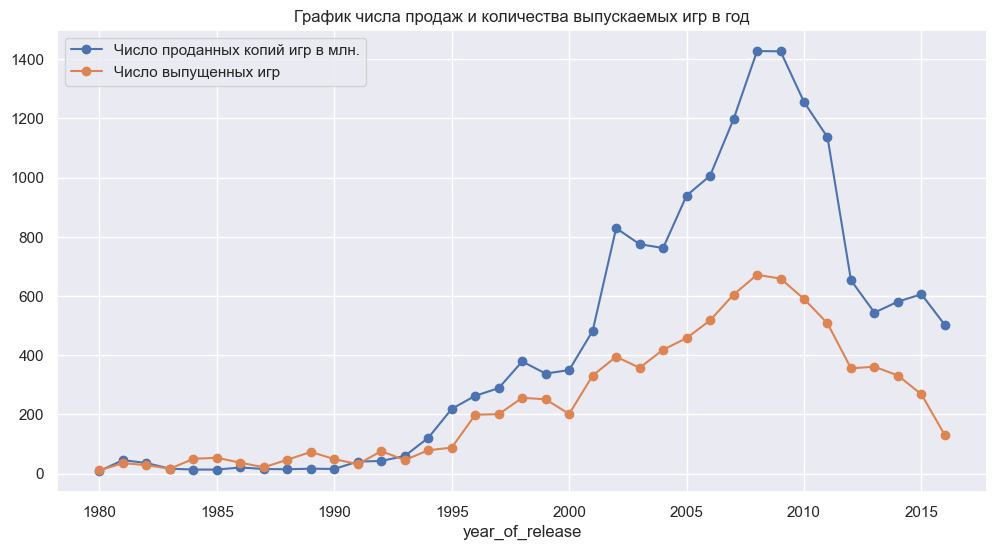

In [16]:
ax = platforms_sales.groupby('year_of_release')\
              .games\
              .sum()\
              .plot(figsize=(12,6), style='o-', label='Число проданных копий игр в млн.')
platforms_sales.groupby('year_of_release')\
         .total_sales\
         .sum()\
         .plot(figsize=(12,6), style='o-', ax=ax, label='Число выпущенных игр')
ax.legend(loc='best')
ax.set_title('График числа продаж и количества выпускаемых игр в год')

Вывод: Из графиков видно, что раньше (примерно до 1995 года) игровая индустрия была слабо развита и количество выпускаемых игр было небольшим. Логично объяснить это низкой технологической базой консолей того времени, а также труднодоступностью их покупки для простого обывателя. Затем начался постепенный рост индустрии вплоть до 2009 года, где она достигла своего пика популярности, после чего резко пошла на спад. Данное явление можно объяснить возникновением глобального кризиса в игровой индустрии и возможной потерей интереса у аудитории к консолям в целом (в то время мог набирать обороты мир мобильных игр)

Теперь немного проанализируем продажи по платформам. Для этого создадим вспомогательную таблицу full_data, содержащую в себе информацию об суммарном количестве произведенных и проданных игр по каждой платформе

In [17]:
full_data = platforms_sales.pivot_table(index='platform', values=['total_sales', 'games'], aggfunc='sum')\
                           .sort_values(by='total_sales', ascending=False)
full_data.head(10)

,games,total_sales
platform,,
PS2,2127,1233.56
X360,1232,961.24
PS3,1306,931.34
Wii,1286,891.18
DS,2121,802.78
PS,1190,727.58
PS4,392,314.14
GBA,811,312.88
PSP,1193,289.53


<AxesSubplot:>

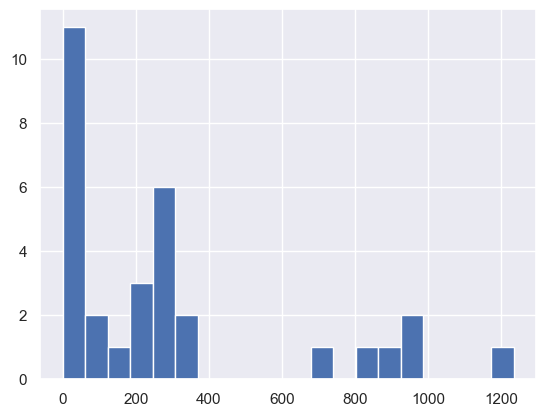

In [18]:
# Посмотрим на график распределения продаж
full_data.total_sales.hist(bins=20)

In [19]:
#Список самых популярных платформ
top_platforms = list(full_data.query('total_sales > 400').index)
top_platforms

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

Вывод: Из графика видно, что платформы четко разделились на две категории: платформы с низкими суммарными продажами (меньше 400 млн. проданных копий) и с высокими (больше 400 млн.). Во вторую категория попали приставки: PS2, X360, PS3, Wii, DS, PS

<AxesSubplot:xlabel='year_of_release', ylabel='total_sales'>

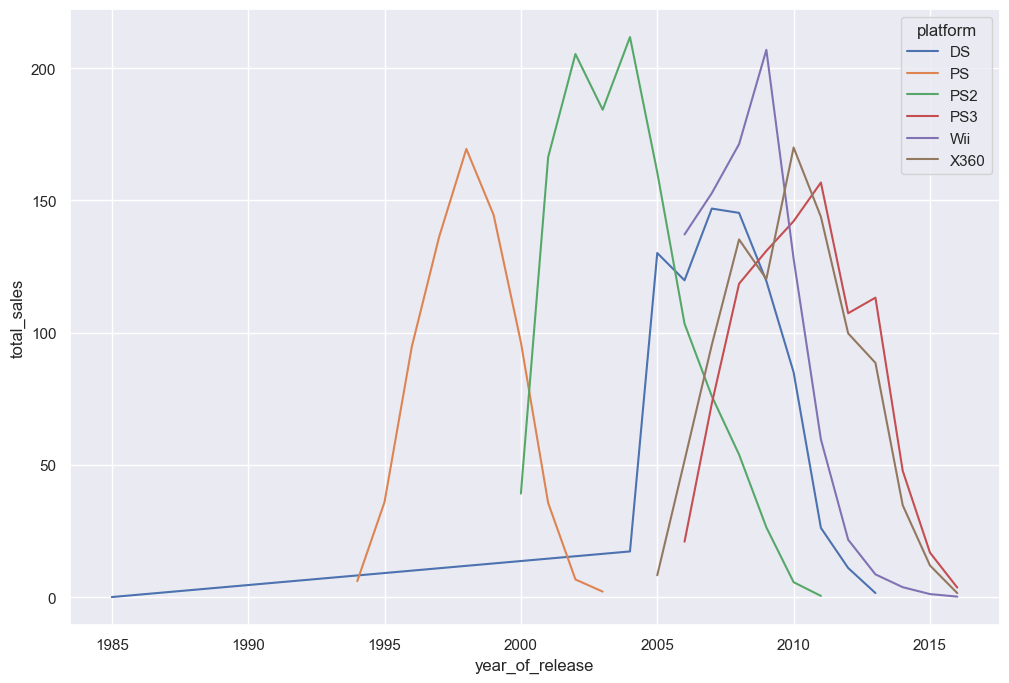

In [20]:
# Построим график продаж по годам для топовых платформ
plt.figure(figsize=(12,8))
sns.lineplot(data=platforms_sales.query('platform in @top_platforms'),
             x='year_of_release', y='total_sales',
             hue='platform')

Единственная платформа, сразу бросающаяся в глаза - это DS, имеющая какую-то аномальную продажу в 1985 году. Детально посмотрим на эту платформу:

In [21]:
print(platforms_sales.query('platform == "DS" '))
gamesdata.query('platform == "DS" and year_of_release == 1985')

   platform  year_of_release  total_sales  games
25       DS             1985         0.02      1
26       DS             2004        17.27     23
27       DS             2005       130.14    118
28       DS             2006       119.81    201
29       DS             2007       146.94    376
30       DS             2008       145.31    492
31       DS             2009       119.54    403
32       DS             2010        85.02    323
33       DS             2011        26.18    153
34       DS             2012        11.01     23
35       DS             2013         1.54      8


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,RP,0.02


Видим, что это аномалия вызвана одной единственной игрой, выпущенной в 1985 году. Логично счесть это за ошибку в данных, так как официальная информация говорит о том, что платформа DS была выпущена в 2004 году. Построим еще раз график с учетом этой неточности:


In [22]:
# Удалил аномальную строчку
platforms_sales = platforms_sales.loc[~((platforms_sales.platform == 'DS') & (platforms_sales.year_of_release == 1985))]

<AxesSubplot:xlabel='year_of_release', ylabel='total_sales'>

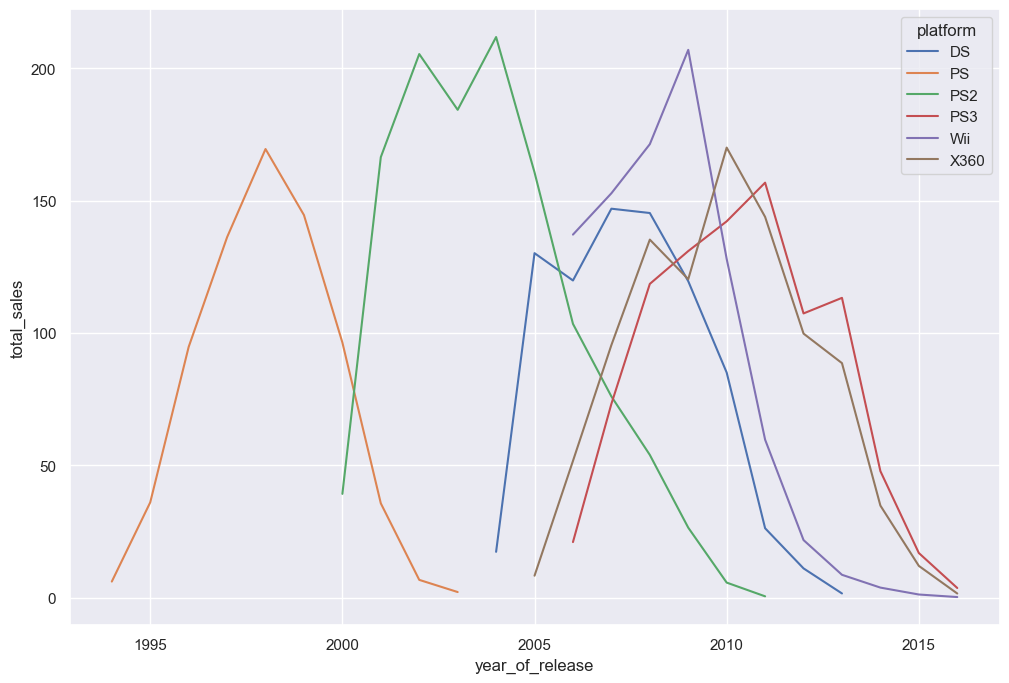

In [23]:
# Новый график
plt.figure(figsize=(12,8))
sns.lineplot(data=platforms_sales.query('platform in @top_platforms'),
             x='year_of_release', y='total_sales',
             hue='platform')

Теперь DS вписывается в общую конву продаж и график больше похож на правду

Вывод: Из графика видно, что все платформы имеют схожую тенденцию: 

1) Консоль выходит на рынок, происходит наращивание клиентской базы и, как следствие, стремительный рост продаж игр

2) Консоль достигает пика своей популярности, а затем начинается постепенный спад продаж и смерть. Это объясняется устареванием технологической базы консолей и выходом новых, более мощных платформ, поддерживающих более современные игры. Это вызывает спад интереса аудитории и, как следствие, падение продаж вплоть до нуля

Рассчитаем среднее время жизни платформы. Можно считать, что это разница между годом последней выпущенной игры и годом первой выпущенной игры на данной платформе:

In [24]:
# рассчитываем среднее время жизни топовых-платформ
platforms_sales.query('platform in @top_platforms')\
               .pivot_table(index='platform',
                            values='year_of_release', 
                            aggfunc=lambda x: x.max()-x.min())\
               .mean()

year_of_release    10.0
dtype: float64

Вывод: установлено, что среднее время жизни платформы составляет 10 лет

Очевидно, что для прогнозирования продаж на 2017 год бесмысленно брать все данные из датасета. При выборе актуального периода для анализа нужно учитывать две вещи:

1) Он должен включать в себя информацию об новых и пользующихся популярностью на данный момент платформах

2) Должен отражать актуальную тенденцию рынка к снижению числа выпускаемых игр 

Поэтом в итоговой выборке логично было бы использовать данные только за последние 5 лет (равному половине характерного времени жизни платформы), которые соотстветствуют временному промежутку c 2011 по 2016 год, так как:

1) Они содержат в себе тенденцию рынка к снижению количества выпускаемых игр

2) Включают себя актуальную информацию как о старых платформах, которые близки к своему устареванию, так и о новых, которые будут еще точно пользоваться спросом приблизительно все последующие 10 лет

In [25]:
actual_gamesdata = gamesdata.query('year_of_release > 2011')
actual_platforms_sales = platforms_sales.query('year_of_release > 2011')

## Анализ платформ

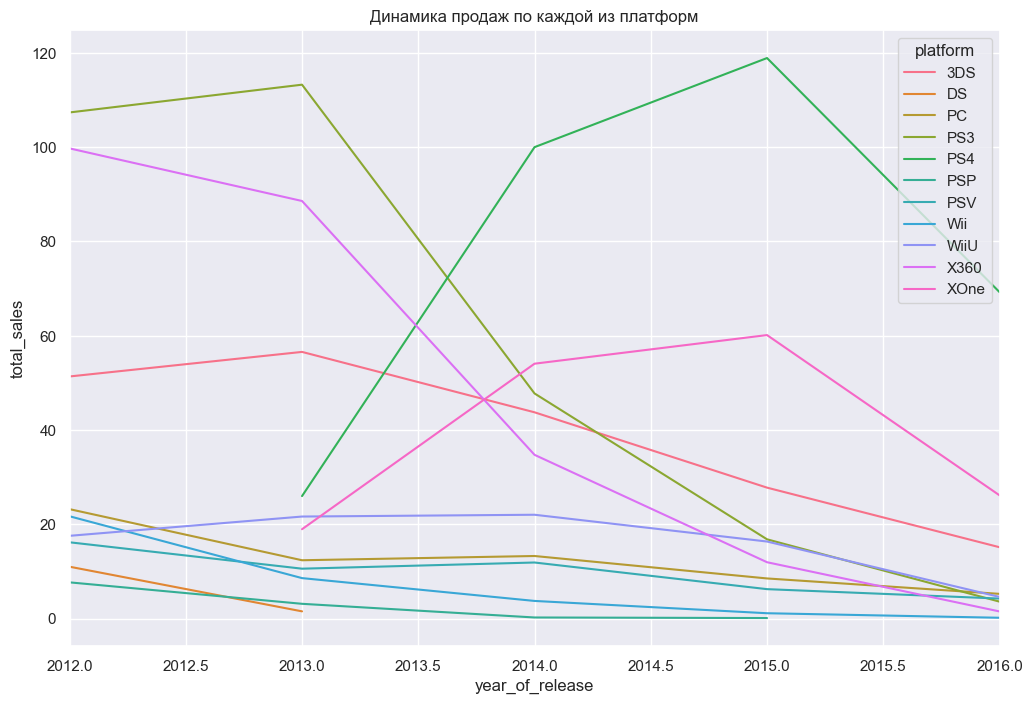

In [26]:
# Посмотрим на динамику продаж каждой из платформ, попвшей в актуальный период
plt.figure(figsize=(12,8))
plt.xlim(2012,2016)
plt.title('Динамика продаж по каждой из платформ')
sns.lineplot(data=actual_platforms_sales,
             x='year_of_release', y='total_sales',
             hue='platform')
plt.show()

Вывод: Из графика видим, что абсолютно все платформы показывают отрицательную тенденцию по росту числа продаж в последние пару лет.
При этом платформы четко можно разделить на две группы: мало прибильные - это те, у которых число продаж за 2016 год менее 20 млн.копий и остальные (сюда попали XOne и PS4). Можно считать вторую группу самыми популярными платформами на текущий момент

Построим график

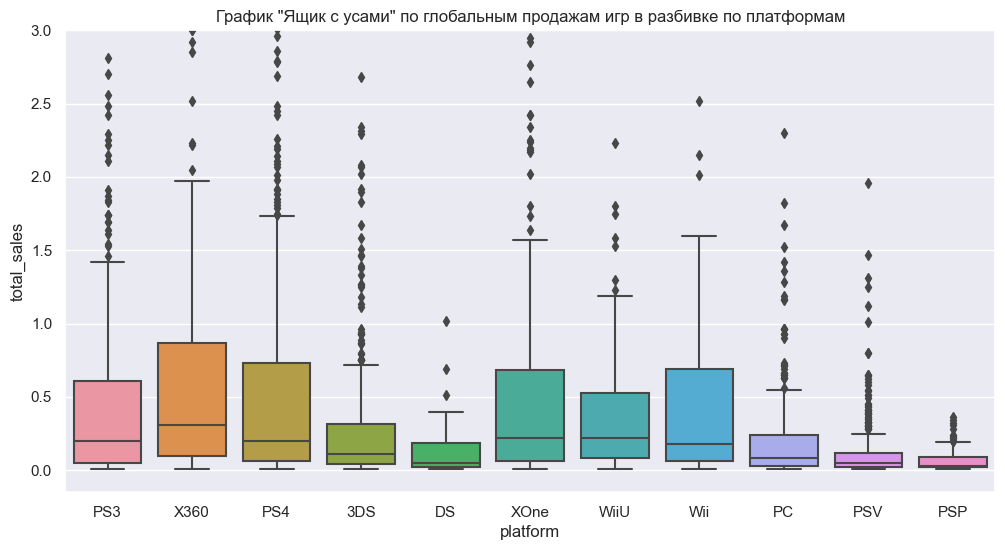

In [27]:
plt.figure(figsize=(12,6))
plt.ylim(-0.15,3)
plt.title('График "Ящик с усами" по глобальным продажам игр в разбивке по платформам')
sns.boxplot(data=actual_gamesdata, y='total_sales', x='platform')
plt.show()

Вывод: По графику видно, что медианное значение числа проданных копий игры для каждой платформы не превосходит полумиллиона. При этом на графике наблюдается огромное число выбросов, то есть игр, имеющих очень большую популярность у геймеров

Взглянем на примеры таких игр платформы PS4:

In [28]:
actual_gamesdata.query('platform == "PS4" and total_sales > 5')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,RP,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,RP,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17
143,FIFA 15,PS4,2014,Sports,0.80,4.33,0.05,0.90,82.0,5.7,E,6.08
154,Destiny,PS4,2014,Shooter,2.49,2.07,0.16,0.92,76.0,6.1,T,5.64
171,Uncharted 4: A Thief's End,PS4,2016,Shooter,1.85,2.50,0.19,0.85,93.0,7.9,T,5.39


Видим, что большая часть представителей - это не просто рядовые игры, а части целых игровых серий (например Call of Duty, FIFA, GTA, Fallout). Такие игры обычно обладают очень высокими бюджетами и большой известностью у пользователей, поэтому неудивительно, что имеют такие высокие продажи

Посмотрим, как влияют на продажи внутри одной популярной платформы (PS4 и XOne) отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами

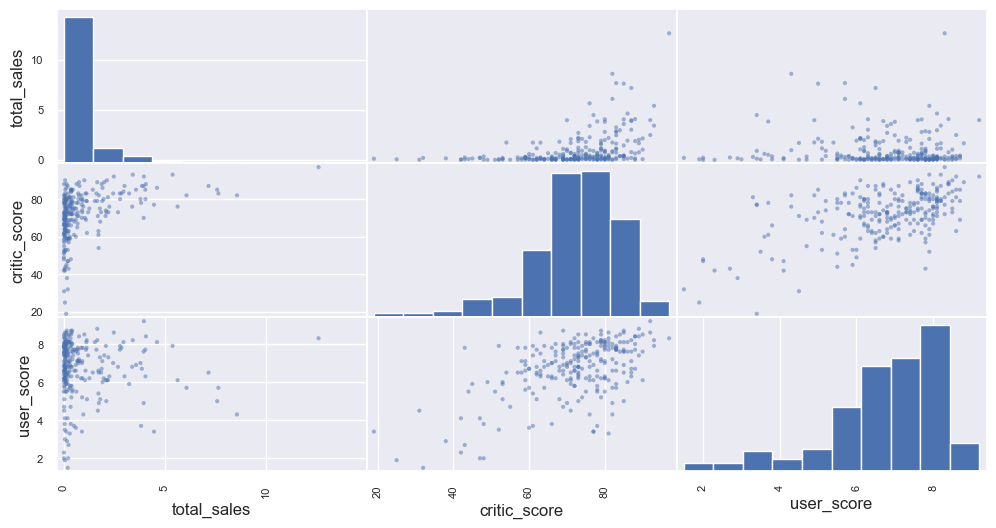

,total_sales,critic_score,user_score
total_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


In [29]:
pd.plotting.scatter_matrix(actual_gamesdata.query('platform =="PS4"')[['total_sales',
                                                                       'critic_score',
                                                                       'user_score']], figsize=(12,6))
plt.show()
actual_gamesdata.query('platform =="PS4"')[['total_sales','critic_score','user_score']].corr()

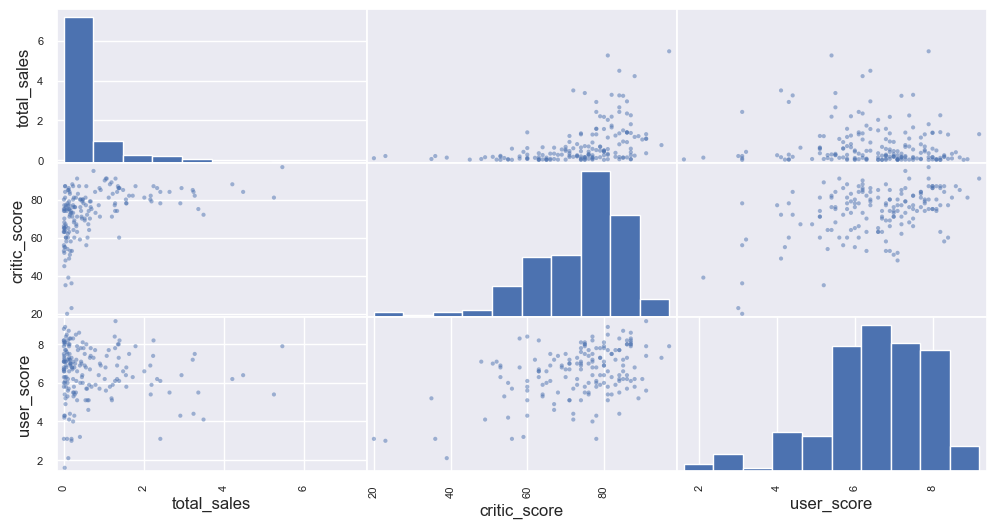

,total_sales,critic_score,user_score
total_sales,1.000000,0.416998,-0.068925
critic_score,0.416998,1.000000,0.472462
user_score,-0.068925,0.472462,1.000000


In [30]:
pd.plotting.scatter_matrix(actual_gamesdata.query('platform =="XOne"')[['total_sales',
                                                                       'critic_score',
                                                                       'user_score']], figsize=(12,6))
plt.show()
actual_gamesdata.query('platform =="XOne"')[['total_sales','critic_score','user_score']].corr()

Вывод: 
Как видно из совместных диаграмм рассеяния и матрицы корелляции, оценки пользователей почти никак не влияют на продажи игры (коэффициент корреляции Пирсона близок 0): есть как игры, которые хорошо воспринимаются пользователями и при этом имеют низкие продажи, так и наоборот, есть игры, имеющие высокие продажи, несмотря на низкие оценки.

В случае оценки критиков эта зависимость имеет более выраженный характер (коэффициент корреляции ~0.4): среди игр с высокими продажами почти не встречаются низкие оценки критиков. 

Теперь посмотрим на общее распределение игр по жанрам. В качестве усреднителя возьмем не среднее арифметическое продаж по данному жанру, а медиану. Это поможет избежать влияния тех сам игр-высокобюджетников, о которых шла речь при обсуждении "ящика с усами"

<AxesSubplot:xlabel='genre'>

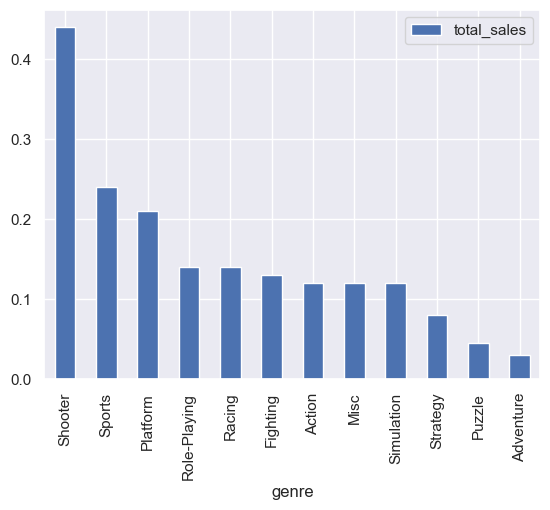

In [31]:
actual_gamesdata.groupby('genre')\
                .agg({'total_sales': 'median'})\
                .sort_values(by='total_sales', ascending=False).plot(kind='bar', y='total_sales')

In [32]:
actual_gamesdata.genre.value_counts()

Action          1031
Role-Playing     370
Adventure        302
Sports           268
Shooter          235
Misc             192
Racing           115
Fighting         109
Platform          85
Simulation        80
Strategy          71
Puzzle            28
Name: genre, dtype: int64

Вывод: как видно из графика самыми популярными жанрами являются Shooter, Sports и Platform.

## Портрет пользователя каждого региона

Определим для пользователей каждого из регионов (NA, EU, JP) самые популярные платформы:

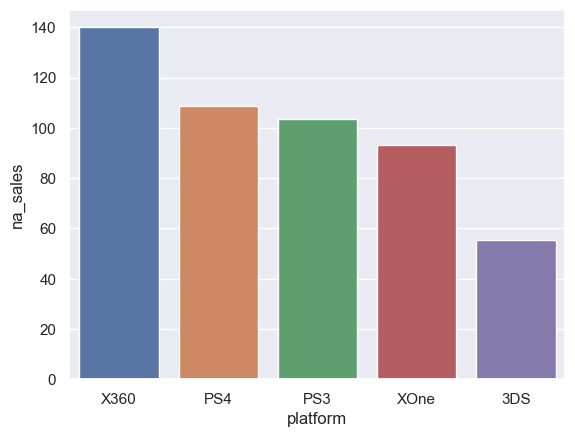

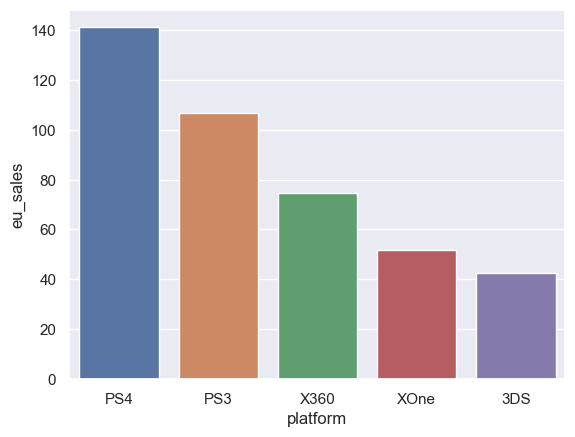

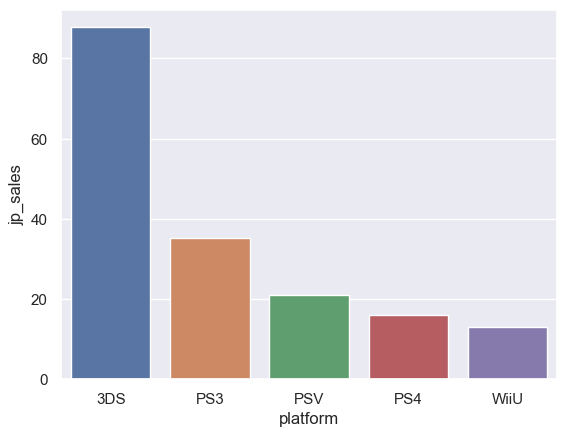

In [33]:
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    region_sales = actual_gamesdata.groupby('platform')\
                               .agg({f'{region}': 'sum'})\
                               .sort_values(by=f'{region}', ascending=False)\
                               .head(5)
    sns.barplot(x=region_sales.index, y=region_sales[f'{region}'])
    plt.show()

Вывод: По большей части рынок Европы и Америки ничем не отличается. Идет конкуренция между топовыми производителями консолей: Microsft и Playstation. Видно, что в Америке еще до сих пор пользуется большой популярностью консоль старого поколения X360, а уже за ней PS4, PS3, XOne и Nintendo 3DS. В Европе первые два места занимают PS4 и PS3, а уже за ними следуют X360, XOne и DS. Ситуация на японском рынке более интересная: здесь большей популярностью пользуется отечественная платформа 3DS, за ней PS3, PSV, PS4 (между прочим, PlayStation тоже японская фирма) и WiiU.

Определим для пользователей каждого из регионов (NA, EU, JP) самые популярные жанры:

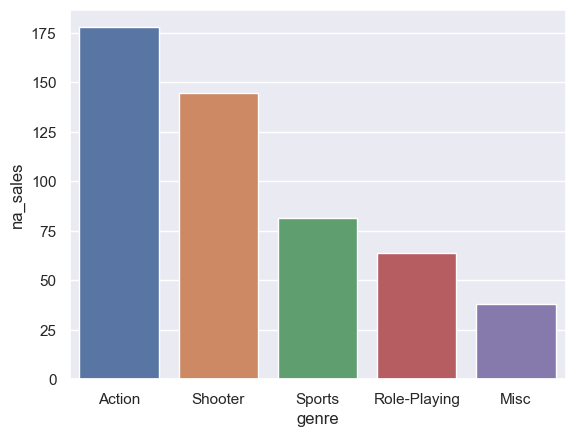

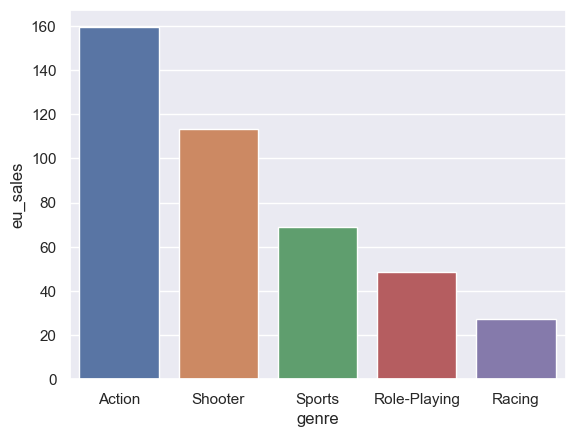

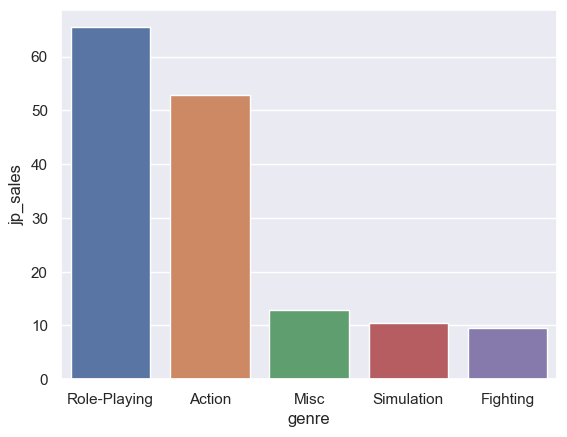

In [34]:
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    region_sales = actual_gamesdata.groupby('genre')\
                               .agg({f'{region}': 'sum'})\
                               .sort_values(by=f'{region}', ascending=False)\
                               .head(5)
    sns.barplot(x=region_sales.index, y=region_sales[f'{region}'])
    plt.show()

Вывод: Распределение жанров в Америке и Европе практически идентично. В Японии большей популярностью обладает жанр Role-Playing

Посмотрим как влияет рейтинг ESRB на продажи в каждом регионе:

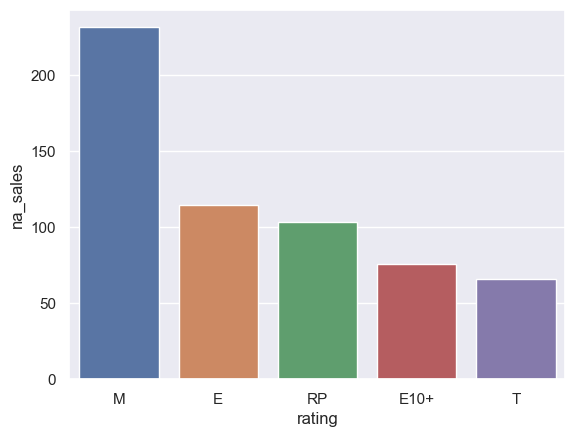

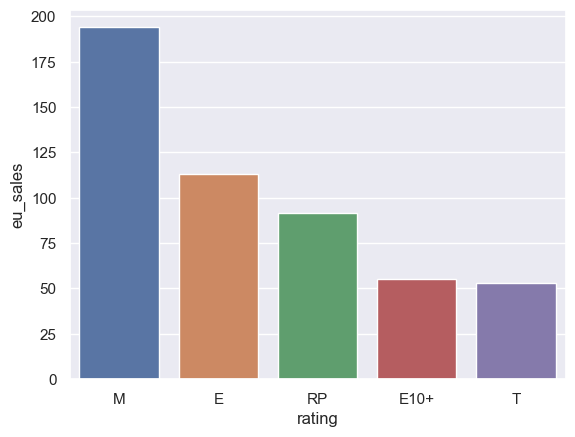

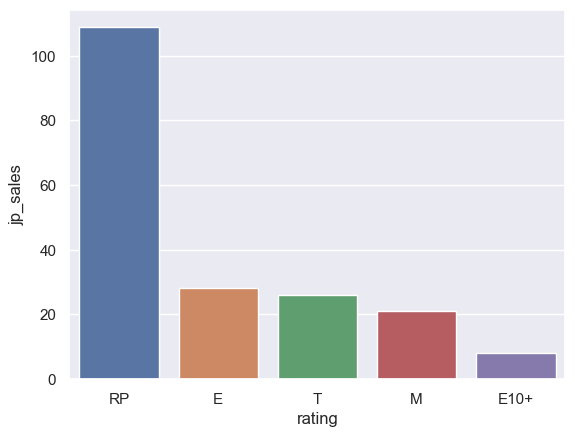

In [35]:
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    region_sales = actual_gamesdata.groupby('rating')\
                               .agg({f'{region}': 'sum'})\
                               .sort_values(by=f'{region}', ascending=False)\
                               .head(5)
    sns.barplot(x=region_sales.index, y=region_sales[f'{region}'])
    plt.show()

Вывод: из графиков видно, что в Европе и Америке большей популярностью обладает рейтинг M (Для взрослых), после чего идем E (для всех возрастов). В Японии ситуация немного другая. Здесь большая часть игр в принципе не имеет оценки по системе ESRB (в начале анализа мы заменили все пропуски в таблице на RP). Возможно, ESRB попросту не пользуется популярностью в Японии, так как является американской системой оценивания, а вместо нее используют другие японские аналоги.

# Проверка статистических гипотез

## Гипотеза 1
Проверим, различаются ли пользовательские рейтинги платформ Xbox One и PC. Так как данные содержат пропуски в оценках, то можно сказать, что мы не обладаем доступом ко всей генеральной совокупности, а имеем дело только лишь с некоторой выборкой. Поэтому для сравнения рейтингов вместо прямого сопоставления средних лучше использовать ttest. Сформулируем нулевую и альтернативную гипотезы

H0: Средняя оценка в генеральной совокупности игр на Xbox равна средней оценке в генеральной совокупности игр на PC

H1: Средние оценки в генеральных совокупностях различны

In [60]:
from scipy import stats as st

xbox_scores = actual_gamesdata.loc[(actual_gamesdata['platform'] == 'XOne') & (actual_gamesdata['user_score'].notna())]\
                              .user_score
pc_scores = actual_gamesdata.loc[(actual_gamesdata['platform'] == 'PC') & (actual_gamesdata['user_score'].notna())]\
                              .user_score

# Был выбран ttest для нахождения статистического различия среднего
# в двух независимых выборках
results = st.ttest_ind(xbox_scores, pc_scores)

alpha = 0.05 #пороговый уровень значимости

print('p-value равно ', results.pvalue)

if (results.pvalue < alpha):
    print('Значение p-value меньше порогового уровня значимости. Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value равно  0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


Вывод: Было получено значение p-value больше заданного порогового, поэтому нет оснований для того, чтобы отклонить нулевую гипотезу. Делаем вывод, что вероятней всего средние пользовательские оценки игр на XOne и PC не отличаются

## Гипотеза 2

H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые

H1: Средние пользовательские рейтинги в генеральных совокупностях различны

In [61]:
action_scores = actual_gamesdata.loc[(actual_gamesdata['genre'] == 'Action') & (actual_gamesdata['user_score'].notna())]\
                              .user_score
sports_scores = actual_gamesdata.loc[(actual_gamesdata['genre'] == 'Sports') & (actual_gamesdata['user_score'].notna())]\
                              .user_score

# Был выбран ttest для нахождения статистического различия среднего
# в двух независимых выборках
results = st.ttest_ind(action_scores, sports_scores)

alpha = 0.05 #пороговый уровень значимости

print('p-value равно ', results.pvalue)

if (results.pvalue < alpha):
    print('Значение p-value меньше порогового уровня значимости. Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value равно  3.716308946093486e-26
Значение p-value меньше порогового уровня значимости. Отвергаем нулевую гипотезу


Вывод: Было получено значение p-value меньшее заданного порогового, поэтому есть основания отклонить нулевую гипотезу. Делаем вывод, что вероятней всего средние пользовательские оценки игр жанров Action и Sports отличаются